## README
#### In the interest of not everyone working on the same file at the same time I suggest creating a copy to work on and then if your code works you can merge it to this main doc.


#### To access the dataset you have to run the "drive.mount" cell, then you'll be given access to google drive where the dataset will be located.

In [ ]:
# adding access to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Data

### https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, classification_report
import random
random.seed(2)
# PyTorch
import torch 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision import models
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn

#Ideally have the same version numbers or similar
!python --version #3.7.13
print(torch.__version__) # 1.11.0+cu113
print(np.__version__) # 1.21.6
print(sklearn.__version__) # 1.0.2

Python 3.7.13
1.11.0+cu113
1.21.6
1.0.2


In [ ]:
# initialize dataset

# dataset = r"/content/drive/MyDrive/comp472-MaskDetector/Face Mask Dataset"
# dataset = r"/content/drive/MyDrive/comp472-MaskDetector/fake dataset"
# real
dataset = r"/content/drive/MyDrive/comp472-MaskDetector/Dataset"

In [ ]:
# new_dataset = os.listdir(dataset) 
# number_files = len(os.listdir(dataset))
# print(number_files)

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Splitting Dataset

In [ ]:
# Script to split dataset into train/test randomly
import splitfolders

if not os.path.exists('/content/drive/MyDrive/comp472-MaskDetector/Dataset/split_dataset'):
  splitfolders.ratio(dataset, # The location of dataset
                   output="/content/drive/MyDrive/comp472-MaskDetector/Dataset/split_dataset", # The output location
                   seed=2, # The number of seed
                   ratio=(.7, .0,.3), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

In [ ]:
BATCH_SIZE = 32
def get_train_data():
    SIZE = (32,32)
    train_dir = '/content/drive/MyDrive/comp472-MaskDetector/Dataset/split_dataset/train'
   
    transform = transforms.Compose([transforms.Resize(SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])

    train_set = datasets.ImageFolder(train_dir, transform=transform)

    trainLoader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

    return trainLoader

def get_test_data():
    SIZE = (32,32)
    test_dir = '/content/drive/MyDrive/comp472-MaskDetector/Dataset/split_dataset/test'
   
    transform = transforms.Compose([transforms.Resize(SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])

    test_set = datasets.ImageFolder(test_dir, transform=transform)

    testLoader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

    return testLoader

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Data Exploration

In [ ]:
classes = classes = ('Cloth Mask', 'N95 Mask', 'No Mask', 'Surgical Mask')

In [ ]:
# get training data
dataiter = iter(get_train_data())
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


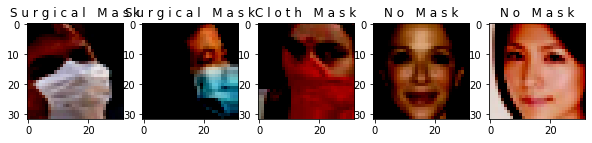

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
for i in range(5):
      ax = axes[i]
      ax.imshow(images[i].permute(1, 2, 0)) 
      ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
plt.show()
plt.savefig('/content/drive/MyDrive/comp472-MaskDetector/OutputImages/displayTrainData.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


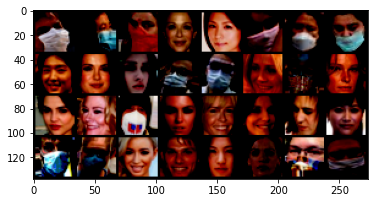

In [ ]:
# show images
imshow(torchvision.utils.make_grid(images))

## Feature Engineering

## Training Model

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        # define the layers using available Pytorch functions
        self.conv1 = nn.Conv2d(3, 32, 5)              # first conv2d 
        self.conv2 = nn.Conv2d(32, 64, 5)             # second conv2d
        self.max_pool = nn.MaxPool2d(2, 2)            # max pool 
        self.avg_pool = nn.AvgPool2d(2, 2)            # average pool
        self.linear1 = nn.Linear(64 * 5 * 5, 120)     # linear 1
        self.linear2 = nn.Linear(120, 90)             # linear 2
        self.linear3 = nn.Linear(90, 16)              # linear 3

    def forward(self, x):
        # calculations using previously defined Pytorch functions
        x = self.conv1(x)                             # conv1 (conv2d) + activation fn + max pool
        x = F.relu(x)                                 # built in relu activation fn
        x = self.max_pool(x)

        x = self.conv2(x)                             # conv2 (conv2d) + activation fn + avg pool
        x = F.relu(x)
        x = self.avg_pool(x)

        x = torch.flatten(x, 1)                       # flatten before linear layers

        x = self.linear1(x)                           # linear 1 + activation fn
        x = F.relu(x)

        x = self.linear2(x)                           # linear 2 + activation fn
        x = F.relu(x)

        x = self.linear3(x)                           # final layer (linear 3)
        return x
        
net = NN()

In [ ]:
# HyperParameters
LEARNING_RATE= 0.001
EPOCHS = 17

criterion = nn.CrossEntropyLoss()                     # loss fn (CrossEntropyLoss - builtin to Pytorch)
optimizer = Adam(net.parameters(), lr=LEARNING_RATE)  # optimize fn (Adam - builtin to Pytorch)

In [ ]:
def train(iterations):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  net.to(device)

  for epoch in range(iterations):  # run the training a certain amount of iterations (epochs)

      running_loss = 0.0
      for i, data in enumerate(get_train_data(), 0):
          inputs, labels = data[0].to(device), data[1].to(device) # get the data, sends to device (device is probably 'cuda:0' to speed it up a bit.)

          optimizer.zero_grad()  # set all tensor gradients to zero for this iteration

          outputs = net(inputs)  # get forward output weights
          loss = criterion(outputs, labels) # calculate loss
          loss.backward()  # backward propogation
          optimizer.step() # update all the parameters for this iteration

        
          running_loss += loss.item() # get running loss
      print(f'[Epoch: {epoch + 1} | Loss: {running_loss/i:.4f}]')  # print loss 
    

  print('Finished Training')

train(EPOCHS)

[Epoch: 1 | Loss: 0.6403]
[Epoch: 2 | Loss: 0.3420]
[Epoch: 3 | Loss: 0.3051]
[Epoch: 4 | Loss: 0.2600]
[Epoch: 5 | Loss: 0.2232]
[Epoch: 6 | Loss: 0.1993]
[Epoch: 7 | Loss: 0.1769]
[Epoch: 8 | Loss: 0.1515]
[Epoch: 9 | Loss: 0.1482]
[Epoch: 10 | Loss: 0.1171]
[Epoch: 11 | Loss: 0.1100]
[Epoch: 12 | Loss: 0.0965]
[Epoch: 13 | Loss: 0.0805]
[Epoch: 14 | Loss: 0.0728]
[Epoch: 15 | Loss: 0.0595]
[Epoch: 16 | Loss: 0.0534]
[Epoch: 17 | Loss: 0.0520]
Finished Training


## Save Model

In [ ]:
PATH ='/content/drive/MyDrive/comp472-MaskDetector/mask_detect_model.pth'
torch.save(net.state_dict(), PATH)  

In [ ]:
# run to grab model
net = NN()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Model Evaluation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

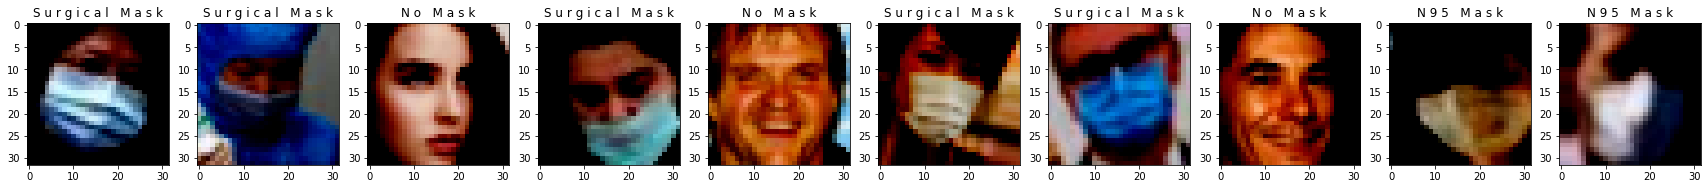

<Figure size 432x288 with 0 Axes>

In [ ]:
# get test data with actual label
dataTestiter = iter(get_test_data())
images, labels = dataTestiter.next()

fig, axes = plt.subplots(figsize=(30, 30), ncols=10)
for i in range(10):
      ax = axes[i]
      ax.imshow(images[i].permute(1, 2, 0)) 
      ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
plt.show()
plt.savefig('/content/drive/MyDrive/comp472-MaskDetector/OutputImages/displayTestData.png')

In [ ]:
predictions = net(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

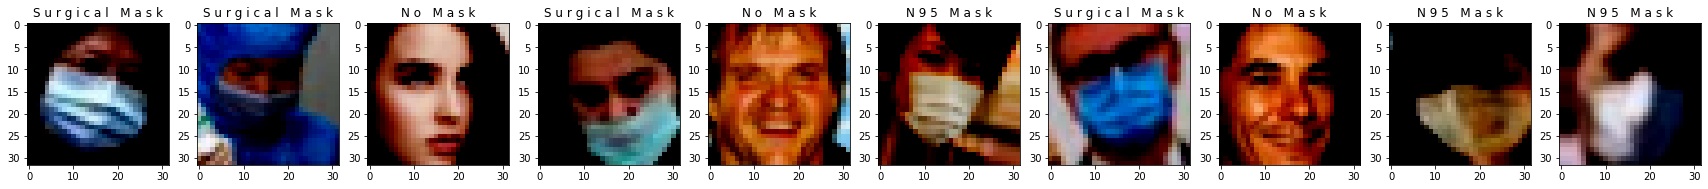

<Figure size 432x288 with 0 Axes>

In [ ]:
# predicted label
_, predicted = torch.max(predictions, 1)


fig, axes = plt.subplots(figsize=(30, 30), ncols=10)
for j in range(10):
      ax = axes[j]
      ax.imshow(images[j].permute(1, 2, 0)) 
      ax.title.set_text(' '.join('%5s' % classes[predicted[j]]))
plt.show()
plt.savefig('/content/drive/MyDrive/comp472-MaskDetector/OutputImages/displayPredictedData.png')

In [ ]:
correct = 0
total = 0
sum = 0

with torch.no_grad():
    for data in get_test_data():
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        sum+= 1

print(f'Accuracy of the network on the {sum*BATCH_SIZE} test images: {100 * correct // total} %')

Accuracy of the network on the 2656 test images: 93 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in get_test_data():
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Cloth Mask is 83.1 %
Accuracy for class: N95 Mask is 79.4 %
Accuracy for class: No Mask is 98.6 %
Accuracy for class: Surgical Mask is 91.5 %


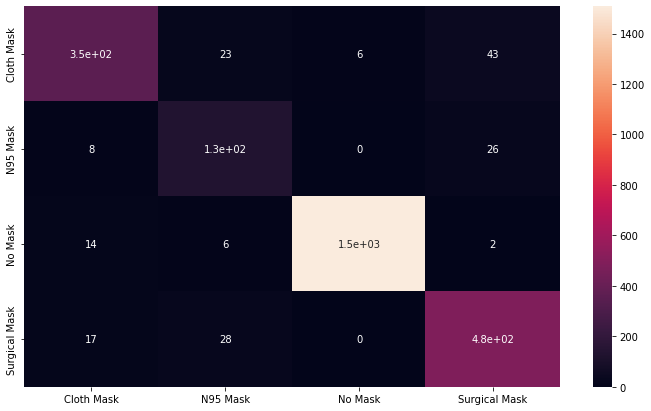

In [ ]:
# confusion matrix
y_pred = []
y_true = []

# iterate over test data
for images, labels in get_test_data():
        output = net(images) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix,
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig('/content/drive/MyDrive/comp472-MaskDetector/OutputImages/confusionMatrix.png')


# build classification report
classification_report = classification_report(y_true,
                                   y_pred,
                                   target_names=classes,
                                   output_dict=True)

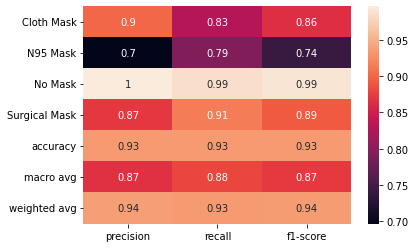

In [ ]:
# classification heatmap
sns.heatmap(pd.DataFrame(classification_report).iloc[:-1, :].T, annot=True)
plt.savefig('/content/drive/MyDrive/comp472-MaskDetector/OutputImages/precision_recall_f1_score.png')